# ECSE 415 - Assignment 4:  Neural Networks
## Theo Ghanem 260972584

## Part 1 - CIFAR-10 Classification using Convolution Neural Network

In [47]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Check the version of PyTorch and CUDA to make sure my laptop's GPU is detected properly

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("-----------------------------")
print(torch.version.cuda)
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
print('*'*10)
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

cuda:0
-----------------------------
12.1
PyTorch version: 2.2.1+cu121
**********
_CUDA version: 
**********
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


### 1. Implement a shallow CNN with the layers mentioned below.
• A Convolution layer with 32 kernels of size 3x3
• A ReLU activation
• A Convolution layer with 64 kernels of size 3x3
• A ReLU activation
• A maxpool layer with kernels size of 2x2
• A convolution layer with 64 kernels of size 3x3
• A ReLU activation
• A convolution layer with 64 kernels of size 3x3
• A ReLU activation
• A flattening layer. (This layer resizes a 3D tensor to a feature vector).
• A fully connected layer with an output size of 10. (Classes should be predicted
as numerical values (like 0-9).

### 2. Use Pytorch Class torchvision.datasets.CIFAR10 to load the dataset.
### 3. Training, validation and test settings are shown below.
• 50,000 images for training (training set). Divide the 10,000 test set images of CIFAR10
into two subsets by 1:1. 5,000 images for validation (validation set), and 5,000 images for
final testing (test set).
• Batch size = 32.
• SGD optimizer with an initial learning rate of 0.002.
• Loss function: categorical cross entropy criterion.
• Training iteration can be 90,000 or more (If you use epoch counting, epoch can be 58 or
more). Perform a validation every 5000 iterations (3 epochs). It may take about 30
minutes on T4 GPU. If you don't have enough computational resources, you are allowed
to reduce the number of images by taking a subset of this dataset or reduce the training
iterations (epochs). State the size of your subset and iterations (epochs) in the README.
• Use the default setting for the rest of the hyperparameters.

In [62]:
from torch.utils.data import Subset

# Define constants
NUM_CLASSES = 10  # Number of classes in CIFAR-10
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.002  # Initial learning rate
NUM_EPOCHS = 58  # Number of epochs for training (you can adjust this)

# Define the size of the subset you want to take
subset_size = 10000  # Adjust this value as needed

# Define data transforms
transform = transforms.Compose([
  transforms.ToTensor(),  # Convert image to tensor
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize data
])

# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Generate a list of indices from 0 to subset_size
indices = list(range(subset_size))

# Create the subset
subset_train_dataset = Subset(train_dataset, indices)

# Split the test set into validation and test sets
validation_size = 5000
test_size = len(test_dataset) - validation_size

val_dataset, _ = torch.utils.data.random_split(train_dataset, [validation_size, len(train_dataset) - validation_size])
test_dataset = torch.utils.data.Subset(test_dataset, indices=range(test_size))

# Create data loaders
train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Define the CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolution layer 1
    self.relu1 = nn.ReLU()  # ReLU activation
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolution layer 2
    self.relu2 = nn.ReLU()  # ReLU activation
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Convolution layer 3
    self.relu3 = nn.ReLU()  # ReLU activation
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Convolution layer 4
    self.relu4 = nn.ReLU()  # ReLU activation
    self.flatten = nn.Flatten()  # Flatten layer
    self.fc = nn.Linear(64 * 16 * 16, NUM_CLASSES)  # Fully connected layer

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.conv2(x))
    x = self.pool(x)
    x = self.relu3(self.conv3(x))
    x = self.relu4(self.conv4(x))
    x = self.flatten(x)
    x = self.fc(x)
    return x


In [64]:
import time

# Initialize the model and optimizer
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_losses, val_losses, val_accuracies = [], [], []

start_time = time.time()  # Record the start time

for epoch in range(NUM_EPOCHS):
  # Training phase
  model.train()
  total_train_loss = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)  # Move data to GPU
    optimizer.zero_grad()  # Reset gradients for each batch
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    total_train_loss += loss.item()

  # Validation phase (after every few training iterations)
  if (epoch + 1) % 1 == 0:  # Validate every 5th epoch
    # if train_iter % 5000 == 0:
    model.eval()
    with torch.no_grad():
      val_loss = 0
      correct = 0
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        output = model(data)
        val_loss += criterion(output, target).item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
      val_acc = correct / len(val_dataset)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      train_losses.append(total_train_loss)
      print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {total_train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}')

end_time = time.time()  # Record the end time

# Save the model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

kernel3x3_runtime= end_time - start_time
print(f'Total execution time: {kernel3x3_runtime} seconds')

Epoch: 1/58 | Train Loss: 720.073 | Val Loss: 360.835 | Val Acc: 0.121
Epoch: 2/58 | Train Loss: 717.728 | Val Loss: 359.142 | Val Acc: 0.175
Epoch: 3/58 | Train Loss: 710.016 | Val Loss: 352.461 | Val Acc: 0.216
Epoch: 4/58 | Train Loss: 679.790 | Val Loss: 331.168 | Val Acc: 0.268
Epoch: 5/58 | Train Loss: 640.192 | Val Loss: 318.021 | Val Acc: 0.280
Epoch: 6/58 | Train Loss: 615.905 | Val Loss: 306.830 | Val Acc: 0.320
Epoch: 7/58 | Train Loss: 595.152 | Val Loss: 297.333 | Val Acc: 0.330
Epoch: 8/58 | Train Loss: 577.826 | Val Loss: 291.259 | Val Acc: 0.337
Epoch: 9/58 | Train Loss: 562.436 | Val Loss: 283.859 | Val Acc: 0.367
Epoch: 10/58 | Train Loss: 548.029 | Val Loss: 276.935 | Val Acc: 0.390
Epoch: 11/58 | Train Loss: 532.018 | Val Loss: 269.792 | Val Acc: 0.397
Epoch: 12/58 | Train Loss: 516.630 | Val Loss: 263.577 | Val Acc: 0.408
Epoch: 13/58 | Train Loss: 505.144 | Val Loss: 258.489 | Val Acc: 0.414
Epoch: 14/58 | Train Loss: 494.832 | Val Loss: 250.440 | Val Acc: 0.433
E

### 4. Plot the training loss, validation loss, and validation accuracy over the training iterations (or epochs). 
#### State whether the training appears to be overfitting and why.

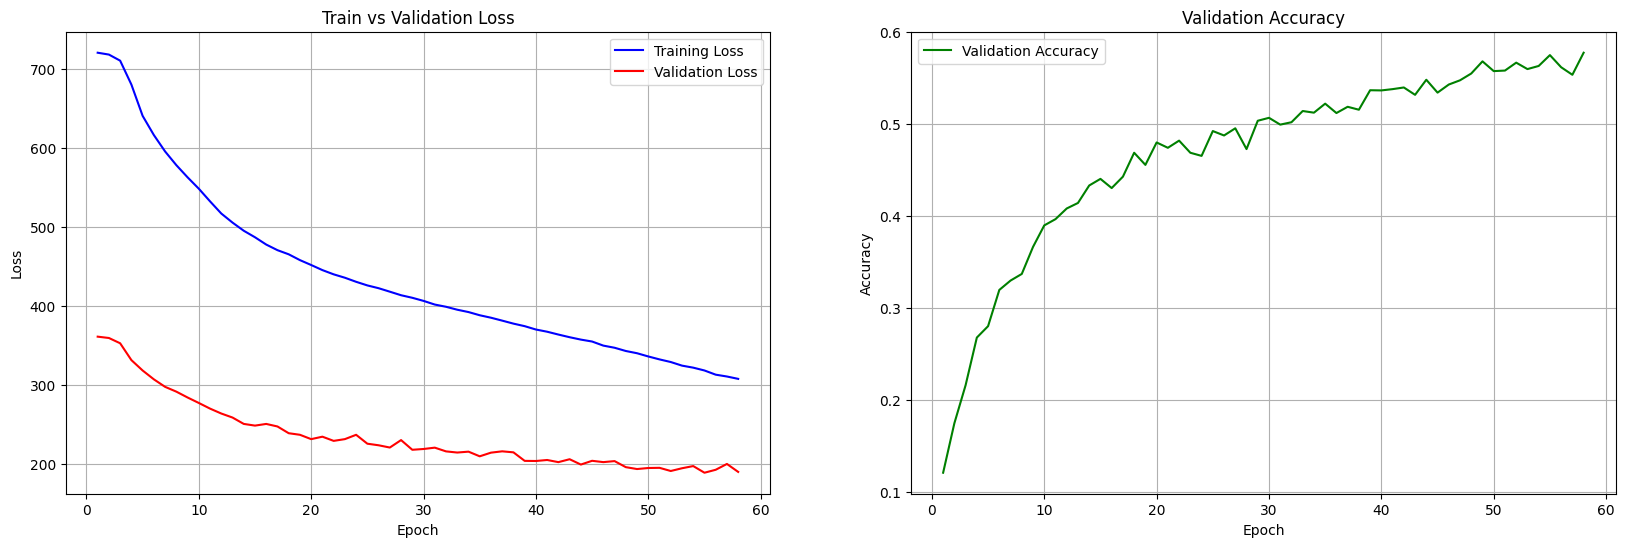

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot for Training loss and Validation loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='r')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for Validation accuracy
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='g')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.show()

### 5. Give the test accuracy on the test set from the epoch where the validation accuracy is maximum as our test accuracy result.



In [68]:
model.load_state_dict(torch.load(PATH))

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the test images: 56.86 %


### 6. Let’s discuss the effects of the Kernel size. Change all kernel sizes to 5x5 and train a new network with the same other hyperparameters. Compare the run time and the test accuracy of models under different kernel sizes and briefly discuss the possible factors that affect the performance of a CNN.

In [69]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)  # Convolution layer 1
    self.relu1 = nn.ReLU()  # ReLU activation
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # Convolution layer 2
    self.relu2 = nn.ReLU()  # ReLU activation
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
    self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)  # Convolution layer 3
    self.relu3 = nn.ReLU()  # ReLU activation
    self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)  # Convolution layer 4
    self.relu4 = nn.ReLU()  # ReLU activation
    self.flatten = nn.Flatten()  # Flatten layer
    self.fc = nn.Linear(64 * 16 * 16, NUM_CLASSES)  # Fully connected layer

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.conv2(x))
    x = self.pool(x)
    x = self.relu3(self.conv3(x))
    x = self.relu4(self.conv4(x))
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [ ]:
import time

# Initialize the model and optimizer
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_losses, val_losses, val_accuracies = [], [], []

start_time = time.time()  # Record the start time

for epoch in range(NUM_EPOCHS):
  # Training phase
  model.train()
  total_train_loss = 0
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)  # Move data to GPU
    optimizer.zero_grad()  # Reset gradients for each batch
    output = model(data)  # Forward pass
    loss = criterion(output, target)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters
    total_train_loss += loss.item()

  # Validation phase (after every few training iterations)
  if (epoch + 1) % 1 == 0:  # Validate every 5th epoch
    model.eval()
    with torch.no_grad():
      val_loss = 0
      correct = 0
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)  # Move data to GPU
        output = model(data)
        val_loss += criterion(output, target).item()
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == target).sum().item()
      val_acc = correct / len(val_dataset)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)
      train_losses.append(total_train_loss)
      print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {total_train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}')

end_time = time.time()  # Record the end time

# Save the model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

print(f'Total execution time: {end_time - start_time} seconds')

Epoch: 1/58 | Train Loss: 720.277 | Val Loss: 361.026 | Val Acc: 0.174
Epoch: 2/58 | Train Loss: 718.401 | Val Loss: 359.317 | Val Acc: 0.171
Epoch: 3/58 | Train Loss: 704.157 | Val Loss: 341.576 | Val Acc: 0.227
Epoch: 4/58 | Train Loss: 650.931 | Val Loss: 322.316 | Val Acc: 0.261
Epoch: 5/58 | Train Loss: 618.967 | Val Loss: 310.042 | Val Acc: 0.293
Epoch: 6/58 | Train Loss: 597.980 | Val Loss: 297.633 | Val Acc: 0.319
Epoch: 7/58 | Train Loss: 574.350 | Val Loss: 287.557 | Val Acc: 0.341
Epoch: 8/58 | Train Loss: 550.550 | Val Loss: 271.268 | Val Acc: 0.385
Epoch: 9/58 | Train Loss: 527.538 | Val Loss: 271.905 | Val Acc: 0.395
Epoch: 10/58 | Train Loss: 509.002 | Val Loss: 259.695 | Val Acc: 0.393
Epoch: 11/58 | Train Loss: 494.938 | Val Loss: 254.960 | Val Acc: 0.407
Epoch: 12/58 | Train Loss: 485.050 | Val Loss: 245.213 | Val Acc: 0.437
Epoch: 13/58 | Train Loss: 474.878 | Val Loss: 241.621 | Val Acc: 0.447
Epoch: 14/58 | Train Loss: 467.024 | Val Loss: 240.434 | Val Acc: 0.448
E

### Plot the training loss, validation loss, and validation accuracy over the training iterations (or epochs). 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot for Training loss and Validation loss
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='r')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for Validation accuracy
axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='g')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.show()

### 7. Use Pytorch Class torchvision.models.resnet18 to implement a deep network ResNet18. Set the training iteration as 6000 or more (If you use epoch counting, epoch can be 5 or more) and perform a validation on the validation set every 500 iterations (1 epoch). Give the test accuracy on the test set from the iteration (or epoch) where the validation accuracy is maximum as the test accuracy result. The rest of the hyperparameters should be the same as the above shallow CNN. Note that:
#### 7.1 By setting the parameter pretrained, you can choose to either train a new ResNet18 model from scratch or fine-tune the ResNet18 model that has been fully trained on the ImageNet dataset.
#### 7.2 Since the image size of CIFAR10 is 32x32 and the standard ResNet18 accepts 224x224 input by default, we may need to first resize the input image to 224x224 (You are free to use other available transformation, such as padding). Besides, the output channel of the final fully connected layer of ResNet18 needs to be modified to 10 to meet the classification requirements of CIFAR10.
Compare the impact of using a pre-trained ResNet18 versus not and discuss the reason. Compare the test accuracy of the deep ResNet18 versus the shallow CNN.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision import models  # Import the models submodule

# Define constants
NUM_CLASSES = 10  # Number of classes in CIFAR-10
BATCH_SIZE = 32  # Batch size for training
LEARNING_RATE = 0.002  # Initial learning rate
NUM_EPOCHS = 20  # Adjust as needed (5 or more)
NUM_ITERATIONS = NUM_EPOCHS * len(train_loader)  # Total training iterations

# Data transforms (including resize)
transform = transforms.Compose([
  transforms.Resize((224, 224)),  # Resize image to 224x224
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset with the new transform
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load validation and test sets with the same transform
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to train and validate the model
def train_validate(model, train_loader, val_loader, optimizer, criterion):
  best_val_acc = 0
  best_model = None

  for epoch in range(NUM_EPOCHS):
    for i, (data, target) in enumerate(train_loader):
      # Training phase (same as previous code)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      if (i + 1) % (len(train_loader)) == 0:  # Validation every epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}], Step: [{i+1}/{NUM_ITERATIONS}], Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}')

        # Update best model based on validation accuracy
        if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model = model.copy()  # Copy the model weights

# Function to perform validation (same as previous code)
def validate(model, data_loader, criterion):
  model.eval()
  with torch.no_grad():
    total_val_loss = 0
    correct = 0
    for data, target in data_loader:
      output = model(data)
      loss = criterion(output, target)
      total_val_loss += loss.item()
      predicted = torch.argmax(output, dim=1)
      correct += (predicted == target).sum().item()
    val_acc = correct / len(data_loader.dataset)
    return total_val_loss / len(data_loader.dataset), val_acc

# Define and load the ResNet18 model
model = models.resnet18(pretrained=False)  # Train from scratch (adjust for fine-tuning)

# Modify the last layer for 10 class output
num_ftrs = model.fc.in_features  # Number of features from the last layer
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)  # Replace with 10 output neurons

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function (same as previous code)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
train_validate(model, train_loader, val_loader, optimizer, criterion)